<a href="https://colab.research.google.com/github/dspix/laspy/blob/main/notebooks/profiles_gee_filtering_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/dspix/laspy.git

In [ ]:
#%%bash
#cd laspy
#git pull origin main

In [28]:
import sys
sys.path.append('/content/laspy/source')
import gee_profiler
import filters

In [3]:
import ee
ee.Authenticate()
ee.Initialize(project='gee-colab-421208') # Project required

In [4]:
import pandas as pd
import numpy as np

import scipy.signal as signal
import matplotlib.pyplot as plt
%matplotlib inline

# MODIS data for time series analysis

Examples using the following MODIS products on Google Earth Engine (GEE).

|Product|Resolution (m)|Desc.|
|:--|---|---|
|MOD13Q1|250|16 day composite and CDOY|
|MOD09GA|500, 1000| Daily with QA (for use with MOD09GQ)|
|MOD09GQ|250|Daily|

To test use the COSMOS site *The Lizard lizrd	50.0327	-5.2000*, which is grassland with mineral soil.

### 1. Profile MOD13Q1 Composite Day of Year

MODIS Composite Day of the Year, [@testa2014] is included in the MOD13Q1 (16 day) composite (also present in MOD09A1, 500m).





To test use the COSMOS site *The Lizard lizrd	50.0327	-5.2000*, which is grassland with mineral soil.



In [5]:
date_from = '2013-01-01'
date_to = '2023-12-31'

point_coord = ee.Geometry.Point([-5.2000, 50.0327])

mod13q1 = gee_profiler.Mod13Q1_profiler()
pro13q1 = mod13q1.to_df(mod13q1.profile(point_coord, date_from, date_to))

# Shift to composite day of the year (CDOY)
pro13q1.index = pro13q1['cdate']
pro13q1.sort_index(inplace=True)

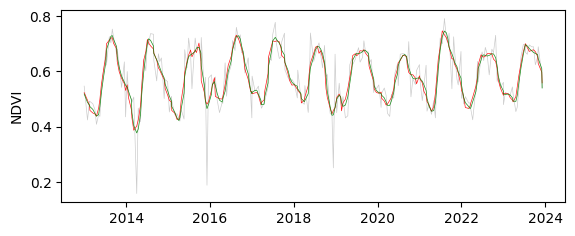

In [30]:
filter_sg = signal.savgol_filter(pro13q1['ndvi'], 10, 2)
filter_w = filters.whittaker(pro13q1['ndvi'].values, 5, d=4)

fig, ax = plt.subplots(figsize=(6.5, 2.5))

ax.plot(pro13q1.index, pro13q1['ndvi'], 'k-', alpha=.2, lw=.5)
ax.plot(pro13q1.index, filter_sg, 'r-', lw=.5, alpha=.9)
ax.plot(pro13q1.index, filter_w, 'g-', lw=.5, alpha=.9)

ax.set_ylabel('NDVI', fontsize=10);

### 2. Smoothed daily MOD09GQ

Smoothed daily MOD09GQ with cloud flag filter (MOD09 internal and MOD35, found in MOD09GA) [@wilson2014] and quality filter. See table below (from table 13 pg. 25 of the MODIS Surface Reflectance User Guide and table 1 in [@wilson2014]).

state_1km_1: Reflectance Data State (16-bit). **Bit 0 is LSB**.
   
|Bit No.|Parameter|Bit comb.|Desc.|Re-class|
|---|---|---|---|---|
|0-1|cloud state|00|Clear|1|
|||01|Cloudy|0|
|||10|Mixed|0|
|||11|Assumed clear|0|
|2|cloud shadow|1|Yes|0|
|||0|No|1|
|10|internal cloud algorithm flag|1|Cloud|0|
|||0|No cloud|1|

Also from MOD09GQ (from table 8, pg. 20 of the MODIS Surface Reflectance User Guide)

QC_250m_1: 250m Reflectance Band Quality. **Bit 0 is LSB**.

|Bit No.|Parameter|Bit comb.|Desc.|Re-class|
|---|---|---|---|---|
|4-7|band 1 data quality|0000|Highest quality|1|
|8-11|band 2 data quality|0000|Highest quality|1|


In [9]:
mod09gq = gee_profiler.Mod09gq_profiler()
mod09ga = gee_profiler.Mod09ga_profiler()

pro09gq = mod09gq.to_df(mod09gq.profile(point_coord, date_from, date_to))
pro09ga = mod09ga.to_df(mod09ga.profile(point_coord, date_from, date_to))

In [10]:
# Quality
f_cstate = pro09ga['cloud_state']!='clear'
f_shadow = pro09ga['cloud_shadow']!='no'
f_cflag = pro09ga['internal_cloud_flag']!='no cloud'

pro09ga.loc[:, 'reclass'] = 1
pro09ga.loc[f_cstate | f_shadow | f_cflag, 'reclass'] = 0

joined = pro09ga.join(pro09gq, lsuffix='_ga', validate='1:1')
clear_gq = joined[joined['reclass']==1]

Filter...

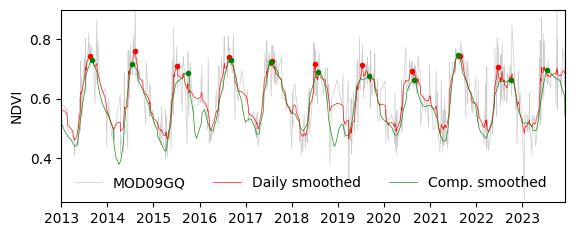

In [29]:
d_filter_sg = signal.savgol_filter(clear_gq['ndvi'], 10, 2)
d_filter_w = filters.whittaker(clear_gq['ndvi'].values, 5, d=1)

fig, ax = plt.subplots(figsize=(6.5, 2.5))

ax.plot(clear_gq.index, clear_gq['ndvi'], 'k-', alpha=.2, lw=.5, label='MOD09GQ')
#ax.plot(clear_gq.index, d_filter_sg, 'r-', lw=.5, alpha=.9)
ax.plot(clear_gq.index, d_filter_w, 'r-', lw=.5, alpha=.9, label='Daily smoothed')
ax.plot(pro13q1.index, filter_w, 'g', lw=.5, alpha=.9, label='Comp. smoothed')

d_peaks, _ = signal.find_peaks(d_filter_w, width=8)
ax.plot(clear_gq.index.values[d_peaks], d_filter_w[d_peaks], 'r.',)

peaks, _ = signal.find_peaks(filter_w, width=8)
ax.plot(pro13q1.index.values[peaks], filter_w[peaks], 'g.',)

ax.set_ylabel('NDVI', fontsize=10)
ax.set_ylim((.25, .9));
ax.set_xlim((pro13q1.index.min(), pro13q1.index.max()))
ax.legend(ncols=3, frameon=False);

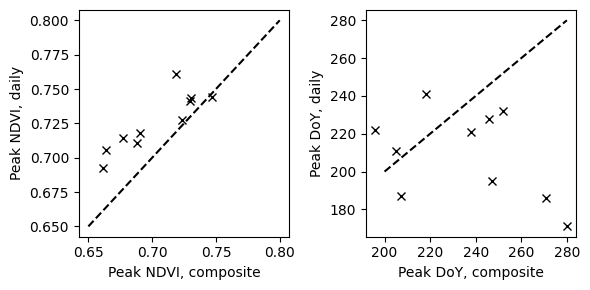

In [26]:
fig, ax = plt.subplots(1, 2, figsize=(6, 3))
ax[0].plot(filter_w[peaks][:-1], d_filter_w[d_peaks], 'kx')
ax[0].plot([.65, .8], [.65, .8], 'k--')
ax[0].set_ylabel('Peak NDVI, daily')
ax[0].set_xlabel('Peak NDVI, composite')

x = pro13q1.index.dayofyear.values[peaks][:-1]
y = clear_gq.index.dayofyear.values[d_peaks]
ax[1].plot(x, y, 'kx')
ax[1].plot([200, 280], [200, 280], 'k--')
ax[1].set_ylabel('Peak DoY, daily')
ax[1].set_xlabel('Peak DoY, composite')

fig.tight_layout()